## Optimizing rotation during training
* Goal is to make a network that will represent all images at some cannonical orientation while being trained on variable orientation images.
* This should result in an overall more simple model able to do the same work.
* Switch between optimizing the model parameters, and optimizing the network.
* Could also do it on one batch at a fixed orientation first, but this is much less cool so we won't

For each batch:
1. Optimize the rotation parameters (randomly), pick the best, couple SGD steps.
2. Do the backward pass to update the weights.

Could iterate this process for a single batch, gradually getting the "best" representation but instead we will hope that over the course of training it will learn it for them all at once.

# TODO
1. Clean this and other notebook
2. Write a bunch of stuff (not exactly sure how to talk about this new addition, if it works). Guess:

**Outline**
We create a method to make VAEs generalize to distribtional shifts in the form of affine transformations, and show experimental results with this method for rotations (and maybe shears). We show that existing methods for enforcing this through data augmentation force an increase in model complexity, or explicit equivariance which results a dramatic increase in memory use and is difficult to scale to more transforms, or are approximate methods, prone to error (STN). This method takes a different approach, where instead of increasing model complexity, increases computational complexity through optimizing the transform to some cannonical orientation.

**ABS/intro**
We propose an alternative method to enable models to generalize to affine transfotmations. We show that data augmentation alone has limitations. We show a method for enabling VAEs trained on a single orientation (a subset of the possible distribution) to generalize, as well as a way to train the VAE on the full distribution, without increasing the model capicity.

The model capicity required to work for this subset of the possible distribution (rotations of 0 degrees) is less than that required for a model expected to generalize to the more broader distribution of all possible rotations. This means that naively using data augmentation should increase the model capacity required.


**Generalizing to Rotations**
Given a VAE trained on images at one orientation $$r_0$$, we can make this model generalize to other rotations taking an image at some rotation, and finding the rotation that minimizes the reconstruction error. This is implemented as: (from paper)

But this procedure requires the images to be supplied at one given orientation, otherwise this model will devolve to the case of just doing data augmenetation, with the increased model capacit required. It would be better to have the model be able to be trained on a dataset without this restriction. 

**Rotation Training**
We use MNIST with random rotations. (or would it have been better to use fixed rotations? probably the same, because we ignore rotation when we train anyway through the random rotation search).

As an alternative to this, we use a procedure where we repeatedly optimize the rotation angle of each image during the training process. The goal is to have the VAE learn some orientation for each class of image that will minimize the loss for a given model complexity. It is not necessarily the case that the best way is to have all stored in the standard orientation we view images. We formulate this in terms of an optimization process added into the training loop, where for each batch of images the rotation of each image is optimized to reduce the model reconstruction loss before backpropagation is done. so overall thee training process is:

for each batch:
* try 20 random rotations $r_opt$, pick the one giving the lowest VAE loss
* do SGD on the rotation with lowest loss
* given this loss $r_opt$, perform standard backprop on the VAE.

This is implemented naively, with no attempt to be efficient. It is likely that it would be more useful to optimize per batch, but these were not tested. Another much better approach would be to combine an STN in the optimization process, as although this is not always correct, it could be much faster than simple random search. Process of use STN, eval, use STN again, ..., but mixed in with randomness and SGD. This way you get the benefit of explicitly optimizing the objective, with faster speed than the random way.

In this way we enable models to be equivariant to rotation through the use of optimization, as an alternative to explicting encoding this into the model (taco) or approximating it (stn). While in this current form the model is practically limited, it could be useful to use this idea of optimizing a representation over some set of transfroms to enforce generalization.

5. Add couple notes to github.

# Summary
Minimial model size through self-supervised generalization.


We have no problem understanding what this is:
[mnist]

Same with this:
[rot mnist]

But convolutional neural networks do not generalize. Look at the loss when MNIST digits are encoded at different rotations:
[loss graph]

Why is it that for a machine learning model to generalize to a rotated image, the most popular method is to feed it the same image at a bunch of different rotations?
[batch of rot mnist]

This rotation augmented method seems strange. Are we really going to force the model to learn a totally different representation for each rotation? It would be niceeer if the model would learn some abstract representation, and then perform some "mental rotation", as was discussed by goeff hinton in ["What is wrong with convolutional neural nets ?"](http://www.youtube.com/watch?v=rTawFwUvnLE&t=19m50s)

In addition to this being unappealing, we can see that if you blindly do data augmentation, greater model complexity is required. We would prefer this to learn a representation with only a single rotation parameter, but it turns out you need to increase the latent loss a lot for this to work.??? I didn this wrong, adding in KL diveregence with multiple variables???




One popular approach, the [Spatial Transformer Network](https://arxiv.org/abs/1506.02025) attempts to solve this problem by applying a learned affine transform to return the image to its original orientation. As long as the network figures out the correct transform, this is exactly the solution!

The issue happens when the model doesn't give the correct transform:
[img at 150 -> img at 45]. 
We would like to iteratively move the image closer and closer to this "cannonical" orientation, based on how "weird" the image looks to us.

But in classification, there is no good metric to measure how weird an image is. The best we can do is something like the classification difficulty/entropy of softmax output.

But when we have a VAE, there's a clear metric for how "weird" an image is, the loss!

So what if when given an image, we optimize the rotation to minimize this loss. We can add an affine transform layer before and after the vae, 

[vae arch]

In this form the whole network is nice and differentiable. So given an image, we can optimize $\theta$ using SDG, the same way we optimize the parameters of the network! In practice, there's some local minima, so some random restarts is required.

And using this, we easily generalize to rotations, and have traded off using an increased model complexity for using increased compute.

[graph of performance on rot with and without affine. (should compare to with rotation augmentation)]

Note that this requires all images to be given to the model in some cannonical orientation at training time. This isn't good! People don't need this, and many datasets don't have this. How can we get around this, and create both a minimal representation by forcing the model to encode only one [basis? subset single otientation single direction fo variance. ] of the dataset during training? If we use data augmentation, we'll force the model to ineffeiciently be able to fully encode all variantion across $\theta$.

An option is to iteratively optimize the transform parameters, $\theta$ **before** SGD is done, for each batch of images. The intuition is that because it is optimal for the model to only learn to encode at a subset of the rotations / single rotation, as training happens the model will gradually start to learn to encode at some rotations better than others, and eventually the model will only be training on a single rotation.
[graph]
[explaination of graph beecause its complicated]
It worked!


[possibly insert the reeduction in variace in angle graph]

So we've got an autoencoder that generalizes to roatation using computation instead of increasing model size!

Here we focused on rotations, but this can easily be extended by changing the affine transform matrix form [] to [].


____________

Note: *Others have realized this too, and other approaches to this problem have included [explicitly encoding for all rotation angles](http://proceedings.mlr.press/v48/cohenc16.pdf), which increases model complexity greatly*

In [1]:
import os
import sys
import json
import math
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image, ImageOps

sys.path.append(str(Path.cwd().parent))
from utils.display import read_img_to_np, torch_to_np
from utils.norms import MNIST_norm
import model.model as module_arch
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
from model.model import AffineVAE
from data_loader.data_loaders import make_generators_MNIST, make_generators_MNIST_CTRNFS

device = torch.device("cuda:0")

In [2]:
def get_model_loaders_config(PATH, device):#old_gpu='cuda:0', new_gpu='cuda:1'):
    """PATH: path to dir where training results of a run are saved"""
    PATH = Path(PATH)
    config_loc = PATH / 'config.json'
    weight_path = PATH / 'model_best.pth'
    config = json.load(open(config_loc))
    
    
    def get_instance(module, name, config, *args):
        return getattr(module, config[name]['type'])(*args, **config[name]['args'])

    data_loader = get_instance(module_data, 'data_loader', config)['train']
    valid_data_loader = get_instance(module_data, 'data_loader', config)['val']
    model = get_instance(module_arch, 'arch', config)
#     model = model.to(torch.device(new_gpu))
#     checkpoint = torch.load(weight_path, map_location={'cuda:0': 'cuda:1'})
    model = model.to(device)
    checkpoint = torch.load(weight_path)
    state_dict = checkpoint['state_dict']
    
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)

    model.load_state_dict(state_dict)
    model = model.to(device).eval()
    
    loss_fn = get_instance(module_loss, 'loss', config)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    return model, data_loader, valid_data_loader, loss_fn, metric_fns, config

In [3]:
def pad_to_size(img, new_size):
    delta_width = new_size - img.size()[1]
    delta_height = new_size - img.size()[2]
    pad_width = delta_width //2
    pad_height = delta_height //2
    img = F.pad(img, (pad_height, pad_height, pad_width, pad_width), 'constant', 0)
    return img

def rotate_mnist_batch(x, return_size=40, fixed_rotation=None):
    """Rotate batch without squishing the img. Pad all imgs to same size"""
    batch_size = x.shape[0]
    rot_x = torch.zeros((batch_size, 1, return_size, return_size))
    for i in range(batch_size):
        img = TF.to_pil_image(x[i, :, :])
        if fixed_rotation:
            img = TF.rotate(img, fixed_rotation)

        img = transforms.ToTensor()(img)
        if return_size:
            img = pad_to_size(img, return_size)
        # MNIST norm, wrong because imgs are padded
        img = transforms.Normalize((0.1307,), (0.3081,))(img)
        rot_x[i, :, :, :] = img
    return rot_x

def AFFINE_MNIST_rot_perf(affine_model, data_loader, loss_fn, device, fixed_rotation, 
                          optimize=False, iterations=0, num_rand_restarts=200, num_imgs=1000):
    """Evaluate performance on MNIST Dataset using a given rotation
    Dataloader should be MNISTCustomTRNFS with size=28x28, unnormalized, not rotated"""

    with torch.cuda.device(device.index):
        affine_model = affine_model.to(device)
        affine_model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for i, (data, target) in enumerate(data_loader):
                batch_size = data.shape[0]
                rot_x = rotate_mnist_batch(data, return_size=40, fixed_rotation=fixed_rotation)
                rot_x, target = rot_x.to(device), target.to(device)
                if optimize:
                    best_affine, loss = affine_model.optimize_rotation(rot_x, num_times=num_rand_restarts, 
                                                                       iterations=iterations)
                else:
                    output = affine_model(rot_x, deterministic=True, theta=0.0)
                    loss = loss_fn(output, rot_x).item()

                total_loss += loss * batch_size
                if i>num_imgs:
                    break

        n_samples = len(data_loader.sampler)
        return total_loss / num_imgs

# Performance of Batch-Optimized VAE
* Comparing the rotation optimized VAE to the one on random rotations to the one trained at a single orientation

In [ ]:
files_dict_loc = '/media/rene/data/MNIST/files_dict.pkl'
data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=1, num_workers=4, 
                                            return_size=28, rotation_range=None, normalize=False)
                                            
config_loc = '/media/rene/data/equivariance/mnist/vae_mnist_L8/0129_171505'
VAE, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, device=device)#old_gpu='cuda:1', new_gpu='cuda:0')
VAE = VAE.to(device)
AffineVAE = getattr(module_arch, 'AffineVAE')
affine_model_single_rot = AffineVAE(pre_trained_VAE=VAE, img_size=28, input_dim=1, output_dim=1, latent_size=8, use_STN=False)
affine_model_single_rot = affine_model_single_rot.to(device)
                                                            
config_loc= '/media/rene/data/equivariance/mnist/vae_mnist_L8_rotate/0204_191133'
VAE, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, device=device)#old_gpu='cuda:1', new_gpu='cuda:0')
VAE = VAE.to(device)
AffineVAE = getattr(module_arch, 'AffineVAE')
affine_model_rand_rot = AffineVAE(pre_trained_VAE=VAE, img_size=28, input_dim=1, output_dim=1, latent_size=8, use_STN=False)
affine_model_rand_rot = affine_model_rand_rot.to(device)
                                            
config_loc = '/media/rene/data/equivariance/mnist/batch_avae_mnist_L8/0404_145427'
affine_model_opt_rot, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, device=device)#old_gpu='cuda:1', new_gpu='cuda:0')
affine_model_opt_rot = affine_model_opt_rot.to(device)
# AffineVAE = getattr(module_arch, 'AffineVAE')
# affine_model_opt_rot = AffineVAE(pre_trained_VAE=VAE, img_size=28, input_dim=1, output_dim=1, latent_size=8, use_STN=False)
# affine_model_opt_rot = affine_model_opt_rot.to(device)
                                            

results = pd.DataFrame()
num_imgs = 1000

for rotation in range(0, 185, 20):
    print(f'rotation: {rotation}')
    log = {}
    log['rotation'] = rotation

    log['loss_single_rot_noopt'] = AFFINE_MNIST_rot_perf(affine_model_single_rot, data_loaders['val'], loss_fn, device,
                                                         fixed_rotation=rotation, optimize=False, iterations=0, 
                                                         num_rand_restarts=1, num_imgs=num_imgs)

    log['loss_single_rot'] = AFFINE_MNIST_rot_perf(affine_model_single_rot, data_loaders['val'], loss_fn, device,
                                                   fixed_rotation=rotation, optimize=True, iterations=30, 
                                                   num_rand_restarts=30, num_imgs=num_imgs)
    
    log['loss_rand_rot'] = AFFINE_MNIST_rot_perf(affine_model_rand_rot, data_loaders['val'], loss_fn, device, 
                                                 fixed_rotation=rotation, optimize=True, iterations=30, 
                                                 num_rand_restarts=30, num_imgs=num_imgs)

    log['loss_opt_rot'] = AFFINE_MNIST_rot_perf(affine_model_opt_rot, data_loaders['val'], loss_fn, device, 
                                                fixed_rotation=rotation, optimize=True, iterations=30, 
                                                num_rand_restarts=30, num_imgs=num_imgs)
    
    results = results.append(log, ignore_index=True)

results.to_csv('/media/rene/code/equivariance/results/affine_L8_rot_compare_all_sgd20_r30_1000t.csv')

fig, ax = plt.subplots()
ax.plot(results['rotation'], results['loss_single_rot_noopt'], label="VAE")
ax.plot(results['rotation'], results['loss_single_rot'], label="AVAE on single orientation")
ax.plot(results['rotation'], results['loss_rand_rot'], label="AVAE on random rotations")
ax.plot(results['rotation'], results['loss_opt_rot'], label="AVAE optimized for each rotation")


ax.set(xlabel='Rotation', ylabel='Loss')
ax.legend(loc='best')

plt.savefig('/media/rene/code/equivariance/imgs/affine_L8_rot_compare_all_sgd30_r30_1000t.png', bbox='tight')
plt.show()

rotation: 0


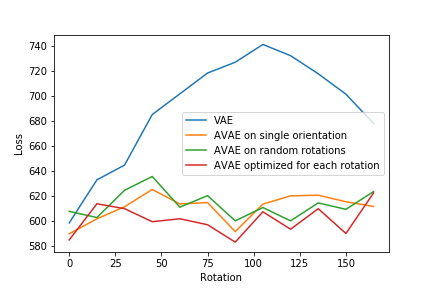

In [5]:
result = Image.open('/media/rene/code/equivariance/imgs/affine_L8_rot_compare_all_sgd20_r40.png')
display(result)

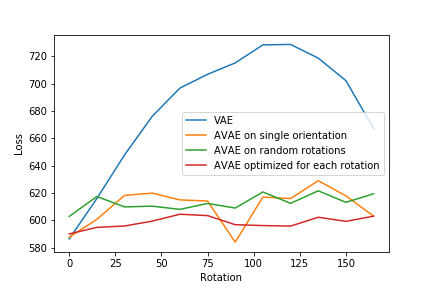

In [8]:
result = Image.open('/media/rene/code/equivariance/imgs/affine_L8_rot_compare_all_sgd20_r20.png')
display(result)

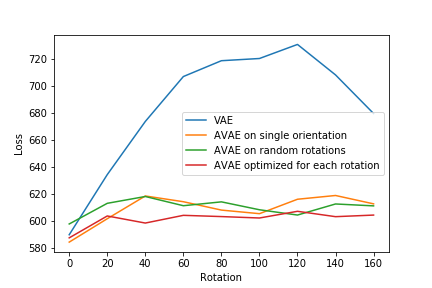

In [6]:
result = Image.open('/media/rene/code/equivariance/imgs/affine_L8_rot_compare_all_sgd20_r30_600t.png')
display(result)

## Results 
* file name is wrong - Actually 600 samples, 20 sgd steps, 30 restarts

In [8]:
results = pd.read_csv('/media/rene/code/equivariance/results/affine_L8_rot_compare_all_sgd20_r40.csv')
results.head()

,Unnamed: 0,loss_opt_rot,loss_rand_rot,loss_single_rot,loss_single_rot_noopt,rotation
0,0,587.161799,597.450877,584.000866,589.461773,0.0
1,1,603.381315,612.757522,601.341289,634.040880,20.0
2,2,598.133986,617.817009,618.212186,673.436713,40.0
3,3,603.851975,610.982988,613.948240,706.727537,60.0
4,4,602.932491,613.845643,607.741598,718.470293,80.0


In [9]:
results.mean(axis=0)

Unnamed: 0                 4.000000
loss_opt_rot             601.232016
loss_rand_rot            609.783722
loss_single_rot          608.559022
loss_single_rot_noopt    684.447139
rotation                  80.000000
dtype: float64

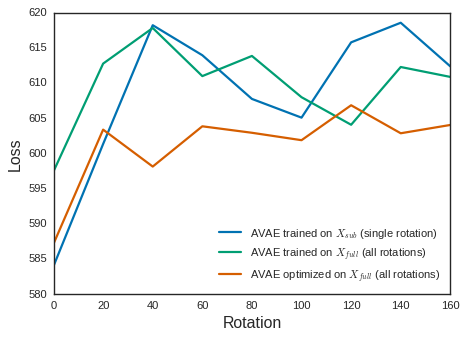

In [58]:
plt.style.use('seaborn-colorblind')
fig, ax = plt.subplots()
ax.plot(results['rotation'], results['loss_single_rot'], label="AVAE trained on $X_{sub}$ (single rotation)",
        linewidth=2)
ax.plot(results['rotation'], results['loss_rand_rot'], label="AVAE trained on $X_{full}$ (all rotations)", 
        linewidth=2)
ax.plot(results['rotation'], results['loss_opt_rot'], label="AVAE optimized on $X_{full}$ (all rotations)", 
        linewidth=2)

ax.set_xlabel('Rotation', fontsize='x-large')
ax.set_ylabel('Loss', fontsize='x-large')
ax.legend(loc='best', prop={'size': 10})
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig('/media/rene/code/equivariance/imgs/affine_L8_rot_AVAE_compare_sgd20_r30_600t.png', bbox='tight')
plt.show()

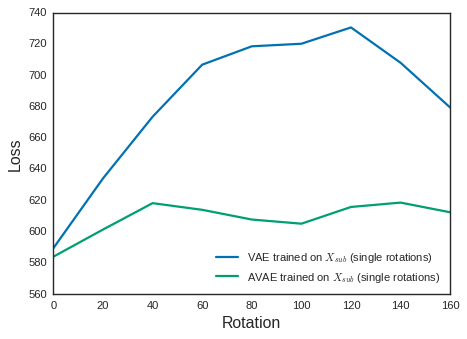

In [59]:
plt.style.use('seaborn-colorblind')

fig, ax = plt.subplots()
ax.plot(results['rotation'], results['loss_single_rot_noopt'], label="VAE trained on $X_{sub}$ (single rotations)",
       linewidth=2)
ax.plot(results['rotation'], results['loss_single_rot'], label="AVAE trained on $X_{sub}$ (single rotations)", 
       linewidth=2)

ax.set_ylim([560,740])
ax.set_xlabel('Rotation', fontsize='x-large')
ax.set_ylabel('Loss', fontsize='x-large')
ax.legend(loc='best', prop={'size': 10})
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig('/media/rene/code/equivariance/imgs/affine_L8_rot_VAE_AVAE_sgd20_r30_600t.png', bbox='tight')
plt.show()